In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow import keras
from matplotlib import pyplot as plt
%matplotlib inline

# 数据处理类(基本不需要修改)

In [2]:
class feature_energing:
    """
        数据处理
        使用：
            fe = feature_energing=(file, params)
            fe.preprocess()
        属性
        origin_df:原始CSV数据
        target_df:处理后数据(需要执行preprocess)
        origin_range:原始数据范围
        target_range：处理后数据范围
        X:自变量df
        Y:因变量df
    """
    def __init__(self, file,
                    columns:'选取的数据维度' = ['C', 'Si', 'Mn', 'Ni', 'Cr', 'Mo', 'Al', 'Co', '等温温度T2', '回火温度T3', '抗拉强度'],
                    scaler:'是否采用数据缩放' = StandardScaler,
                    regression:'用于分类还是回归'= True,
                    shuffle:''= True,
                    random_seed:''= 1,
                    categories:'分类类别' = 4,
                    onehot:'是否使用onehot'= False,
                    info:'是否打印信息' = True,
                    ranges:'数据范围'= {'C':[0, 1.2],
                              'Si':[0, 4],
                              'T3':[25, 450],
                              'Y':[900, 2500],
                              },
                 ):
        self.columns = columns
        self.scaler = scaler
        self.regression = regression
        self.shuffle = shuffle
        self.random_seed = random_seed
        self.categories = categories
        self.onehot = onehot
        self.info = info
        self.ranges = ranges
        self.origin_df = pd.read_excel(file, header=2)
        self.origin_df = self.origin_df[self.origin_df.index.notnull()]
        pass

    def preprocess(self):
        """
        对数据进行处理
        :return:
        """
        if self.info:print('对数据进行回归处理' if self.regression else '对数据进行分类处理')

        df = self.origin_df[self.columns]
        if self.info:
            print('列名:', df.columns)
            df.info()

        # 重命名列名
        df = df.rename(columns={'等温温度T2': 'T2', '回火温度T3': 'T3', '抗拉强度': 'Y'})

        ## 数据处理
        df = df.fillna(value=0)

        # 转成Float
        df = df.loc[:, :].apply(pd.to_numeric, errors='coerce')

        # 强度处理
        df = df[df.Y >= self.ranges['Y'][0]]
        df = df[df.Y <= self.ranges['Y'][1]]
        if self.info:print('--Del Y not in range:', np.shape(df))

        # C处理 Nan的为不是数字的
        df = df[df.C.notnull()]
        df = df[df.C >= self.ranges['C'][0]]
        df = df[df.C <= self.ranges['C'][1]]
        if self.info:print('--Del C not in range:', np.shape(df))

        #
        df = df[df.T2.notnull()]
        # df = df[df.T2 >= self.ranges['T2'][0]]
        # df = df[df.T2 <= self.ranges['T2'][1]]
        if self.info:print('--Del T2 None', np.shape(df))

        #
        df.loc[(df.T3 == 0), 'T3'] = 25
        df = df[df.T3 >= self.ranges['T3'][0]]
        df = df[df.T3 <= self.ranges['T3'][1]]
        if self.info:print('--Del T3 not in range:', np.shape(df))

        # 其它元素位置 None填充0
        df = df.fillna(value=0)
        ##

        # 各维度最大最小值
        mins = np.min(df, axis=0)
        maxs = np.max(df, axis=0)
        self.origin_range = pd.DataFrame([mins, maxs], index=['min:', 'max'], columns=self.columns)
        # if self.info: print('原始数据范围:', self.origin_range, sep='\n')

        X = df.iloc[:, :-1].values
        y = df.Y.values
        if not self.regression:     # 非回归处理label
            y = self.deal_labels(y)

        self.target_df = df

        self.X = X
        self.Y = y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=self.shuffle,
                                                            random_state=self.random_seed)

        # 数据缩放
        if self.regression :
            s = MinMaxScaler().fit(X_train)
            X_train = s.transform(X_train)
            X_test = s.transform(X_test)
            
            y_train = (y_train-900)/(2500 - 900)
            y_test = (y_test-900)/(2500 - 900)

        # 各维度最大最小值
        mins = np.min(df, axis=0)
        maxs = np.max(df, axis=0)
        self.target_range = pd.DataFrame([mins, maxs], index=['min:', 'max'], columns=df.columns)
        if self.info:print('处理后各维度范围:', self.target_range, sep='\n')

        self.X_train = X_train
        self.y_trian = y_train
        self.X_test = X_test
        self.y_test = y_test
        print('处理完成:', np.shape(df))
        return X_train, X_test, y_train, y_test

    def deal_labels(self, y):
        """
        将类别进行离散表示
        """
        min_ = np.min(y)
        max_ = np.max(y)

        # 设置分类边界
        bounds = np.linspace(min_ - 1, max_, self.categories + 1)

        if self.info: print('类别统计:', np.histogram(y, bounds)[0])

        # 画图
        if False:
            from matplotlib import pyplot as plt
            plt.hist(y, bounds)
            plt.title('Split Data with 4 categories')
            plt.xlabel('Tensile Strength')
            plt.ylabel('Count')
            plt.show()

        # 转换类别编号
        y = [(bounds >= i).nonzero()[0][0] for i in y]
        # 编号下标从0开始
        y = y - np.array([1])
        y = y.ravel()

        # 是否使用onehot表示类别
        if self.onehot:
            y = np.array(y).reshape(-1, 1)
            enc = OneHotEncoder()
            y = enc.fit_transform(y).toarray()
        return y


def compute_pearson(x, y):
    """
    计算pearson系数
    :param x:
    :param y:
    :return:
    """
    pearson = []
    for i in range(x.shape[1]):
        x_ = np.hstack(x[:, i])
        y_ = np.hstack(y)
        pearson.append(np.corrcoef(x_, y_)[1, 0])
    return pearson
    pass


def drawpic(df):
    from matplotlib import pyplot as plt
    plt.scatter(df.C, df.Y)
    plt.title('Carbon and tensile strength relationship scatter plot')
    plt.xlabel('Carbon content (wt.%)')
    plt.ylabel('Tensile Strength (MPa)')
    plt.show()


def evaluate_classifier(y, y_pred):
    """
    评估
    :param y:
    :param y_predt:
    :return:
    """
    # 计算F1 Recall support
    from sklearn.metrics import precision_recall_fscore_support as score
    precision, recall, fscore, support = score(y, y_pred)
    table = pd.DataFrame({'precision': precision, 'recall': recall, 'fscore': fscore, 'support': support})
    print(table)
    return table


def evaluate_regression(y, y_pred):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    y = y.ravel()
    y_pred = y_pred.ravel()
    print(f'MAE:{int(mean_absolute_error(y, y_pred))}')
    print(f'MSE:{int(mean_squared_error(y, y_pred))}')
    print(f'RMSE:{int(np.sqrt(mean_squared_error(y, y_pred)))}')
    print('抽样随机结果对比：')
    index = np.random.randint(1, 100)
    result = pd.DataFrame([y[index:index+5], y_pred[index:index+5]], index=['y', 'y_pred'])
    # print(result)
    pass

# 评估方法
直接将预测结果与真是结果输入

In [3]:
def evaluate_regression(y, y_pred, kuoda=False):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    y = y.ravel()
    y_pred = y_pred.ravel()
    
    if kuoda:
        y_pred = y_pred*(2500-900) + 900
        y = y*(2500-900) + 900
    MAE = int(mean_absolute_error(y, y_pred))
    MSE = int(mean_squared_error(y, y_pred))
    RMSE = int(np.sqrt(mean_squared_error(y, y_pred)))
    print(f'MAE:{int(mean_absolute_error(y, y_pred))}')
    print(f'MSE:{int(mean_squared_error(y, y_pred))}')
    print(f'RMSE:{int(np.sqrt(mean_squared_error(y, y_pred)))}')
    index = np.random.randint(1, 50)
    result = pd.DataFrame([y[index:index+5], y_pred[index:index+5]], index=['y', 'y_pred'])
    print('抽样随机结果对比：')
    print(result)
    return MAE,MSE,RMSE

# GridSearch

准备数据

In [4]:
# df = pd.read_csv(r'/mnt/d/Documents/材料学院/data/贝氏体钢数据-fixedT3(320).csv')
df = pd.read_excel(r'/mnt/d/Documents/材料学院/data/wd0331.xlsx')
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=10)

x = df.iloc[:, :8].values
y = df.Ymean.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=7)

# 默认gbr模型效果  baseline
gbr.fit(x_train, y_train)
y_pred = gbr.predict(x_test)
evaluate_regression(y_test,y_pred)

MAE:32
MSE:1392
RMSE:37
抽样随机结果对比：
Empty DataFrame
Columns: []
Index: [y, y_pred]


(32, 1392, 37)

最优模型检索

In [5]:
from sklearn.model_selection import GridSearchCV

# 待寻参列表
parameters = {
    'n_estimators':range(5,500,20),
    'max_depth':range(3,20)
}

gbr = GradientBoostingRegressor(random_state=10)

gsearch = GridSearchCV(estimator = gbr, n_jobs=-1, cv = 10, verbose=1, param_grid=parameters)
gsearch.fit(x,y)

Fitting 10 folds for each of 425 candidates, totalling 4250 fits


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1351 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 2601 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 4250 out of 4250 | elapsed:   52.0s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(5, 500, 20), 'max_depth': range(3, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

寻参完成，评估，保存模型

In [6]:
y_predict = gsearch.best_estimator_.predict(x)
evaluate_regression(y_predict,y)

from sklearn.externals import joblib
joblib.dump(gsearch.best_estimator_, r'/mnt/d/Documents/材料学院/models/fixedT3(320).sav')

MAE:17
MSE:452
RMSE:21
抽样随机结果对比：
                  0            1            2            3            4
y       1406.638423  1404.303998  1377.405487  1615.329528  1552.027264
y_pred  1371.000000  1390.000000  1356.000000  1616.000000  1549.000000


['/mnt/d/Documents/材料学院/models/fixedT3(320).sav']

# 数据子集分析
## 固定T3温度为320
T3=320, C=0.7下   T2与Y负相关

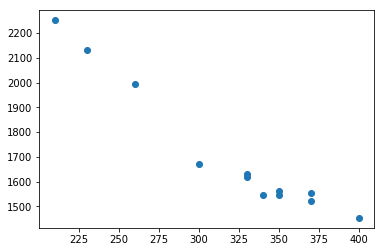

In [7]:
df = pd.read_excel(r'/mnt/d/Documents/材料学院/data/wd0331.xlsx')
df = df[df.T2 > 0]
df = df[df.C == 0.7]

plt.scatter(df.T2, df.Ymean)
plt.show()

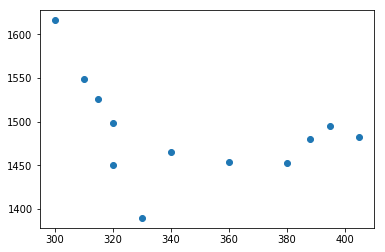

In [8]:
df = pd.read_excel(r'/mnt/d/Documents/材料学院/data/wd0331.xlsx')
df = df[df.T2 > 0]
df = df[df.Si == 1.48]

plt.scatter(df.T2, df.Ymean)
plt.show()

In [9]:
df = pd.read_csv(r'/mnt/d/Documents/材料学院/data/贝氏体钢数据-fixedT3(320).csv')

# 对元素进行round
round_columns = ['Si', 'Mn', 'Ni', 'Cr', 'Mo', 'Al']
decimals = pd.Series([1]*len(round_columns), index=round_columns)
df = df.round(decimals)
df.loc[df.C == 0.71, 'C'] = 0.7

df = df.groupby(['C', 'Si', 'Mn', 'Ni', 'Cr', 'Mo', 'Al', 'T2', 'T3'])

df.head()

,C,Si,Mn,Ni,Cr,Mo,Al,T2,T3,Y
0,0.92,1.6,0.7,0.3,1.7,0.3,0.1,320,320,1420
1,0.70,2.6,0.6,0.0,0.6,0.0,0.0,210,320,2252
2,0.70,2.6,0.6,0.0,0.6,0.0,0.0,230,320,2096
3,0.70,2.6,0.6,0.0,0.6,0.0,0.0,230,320,2167
4,0.70,2.6,0.6,0.0,0.6,0.0,0.0,260,320,2000
5,0.70,2.6,0.6,0.0,0.6,0.0,0.0,260,320,1985
6,0.70,2.6,0.6,0.0,0.6,0.0,0.0,300,320,1671
7,0.70,2.6,0.6,0.0,0.6,0.0,0.0,330,320,1655
8,0.70,2.6,0.6,0.0,0.6,0.0,0.0,350,320,1534
9,0.70,2.6,0.6,0.0,0.6,0.0,0.0,350,320,1564
